# Arasu Fixed Frame Sliding Windows(FFSW)
Project by Vladislav Savchuk

## Problem 

There have been several solution for a problem of computing quantiles without storing all values.

Another problem is when you don't want to compute quantiles on the whole stream, but only on some limited window.
![](imgs/index.jpg)

## Idea

Arasu proposess an algorithm that allows for the approximate computation of the quantiles where you track multiple layers of copies for the stream and split it into several blocks of the same size. You can compute separately for each block the quantile using GK algorithm and then combine them using best blocks over all layers into single value that was proven to be in $\epsilon$-approximation of the real rank

![](imgs/cover01.png)

In [1]:
from arasu import *
import time
import gc
from tqdm.notebook import tqdm
import tracemalloc

As for implementation of ArasuFSSW we were required to implement GK algorithm, let's also proffile it as well (I will restart the kernel to clear any possible memory leaks)

Unfortunately there isn't much memory profilers available for the jupyter notebook.

I've chosen tracemalloc, it seems to be able to trace the memory our algorithm uses

### GK

Although GK didn't stated the time values we still can profile it.

The worst space complexity is $O(\dfrac{1}{\epsilon}\log{\epsilon N})$, which means that it's dependent on the seen querries

In [2]:
def test_gk():
    tracemalloc.start()
    current, peak = tracemalloc.get_traced_memory()
    gk = GK(0.0625)
    np.random.seed(42)
    values = np.random.normal(size=5000)
    acc_error = deque(maxlen=100)
    total = 0
    mean_times_quantile = []
    time_to_insert = []
    memory_consumption = [current]
    pbar = tqdm(enumerate(values))
    for ind, v in pbar:
        cur_time = time.time()
        gk.insert(v)
        time_to_insert.append(time.time() - cur_time)
        current, peak = tracemalloc.get_traced_memory()
        memory_consumption.append(current)
        # Basic property of GK
        assert np.sum(gk.values.gs) == gk.total_count
        
        times = []
        # quant should belong to (0, 1], this is just an example arrangement
        for quant in np.arange(0.10, 1.01, 0.1):
            # By definition the result in quantiles should be around floor((quant - eps)N) and floor((quant - eps)N)
            
            # Get the rank
            r = int(np.ceil(quant * (ind + 1)))
            # Sort the sequence
            srted = sorted(values[:ind + 1])
            # Get quantile (rank - 1 for python lists)
            hand_computed_quant = srted[r - 1]

            # Get the eps*N
            max_error = int(np.floor(gk.eps * gk.total_count))

            # Compute absolute error (just for statistics)
            cur_time = time.time()
            answer = gk.quantile(quant)
            times.append(time.time()-cur_time)
            
            error = abs(hand_computed_quant - answer)
            acc_error.append(error)
            try:
                # The value returned by the GK should be inside this error
                assert answer in srted[r - max_error - 1:r + max_error]
                pbar.set_description(f"MAE : {np.mean(acc_error):.2f}" + \
                                     f" | Max Err: {int(np.floor(gk.eps * gk.total_count))}" + \
                                     f" | Items: {len(gk.values)}" + \
                                     f" | Passed: {total} tests ")
                total += 1
            except AssertionError as e:
                print(f"Test failed to find rank {r} with max error {max_error}," + \
                      f"as {gk.quantile(quant)} not in srted[r - max_error - 1:r + max_error]")
                print(gk.quantile(quant))
                raise e
        mean_times_quantile.append(np.mean(times))
    tracemalloc.stop()
    return mean_times_quantile, time_to_insert, memory_consumption

In [3]:
times = test_gk()

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Overall as we can see the mean absolute accuracy is good and the algorithm always provides us with $\epsilon$-approximate quantiles and we only need to store around 20 items to compute this approximation. Nice

### Mean time to compute quantile

It's seems that the time to compute quanntile doesn't depend on the amount of seen items

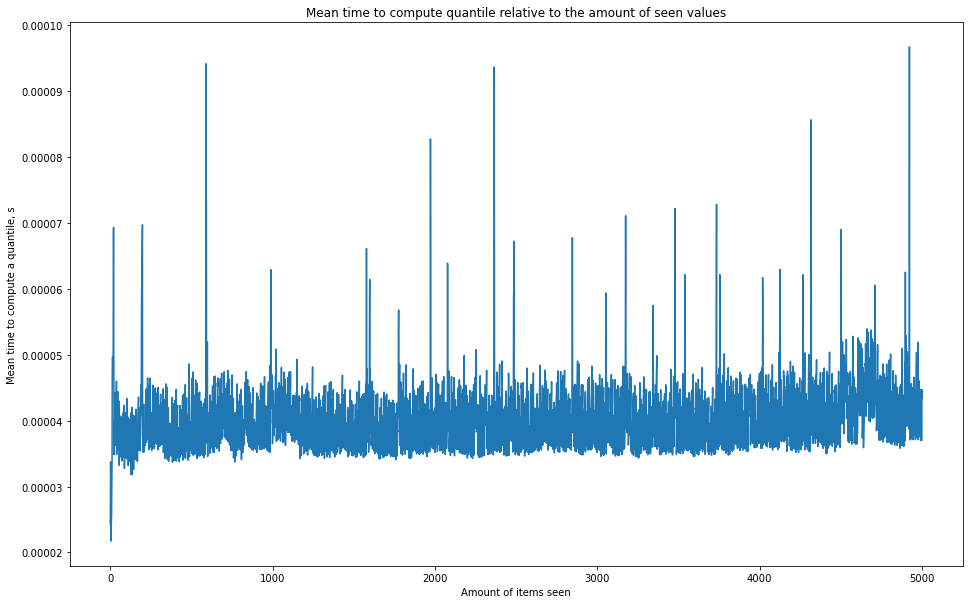

In [4]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,10))
plt.plot(times[0])
plt.xlabel('Amount of items seen')
plt.ylabel('Mean time to compute a quantile, s')
plt.title('Mean time to compute quantile relative to the amount of seen values')
plt.show()

### Mean time to add new item

The time to add new items also seem constant (maybe there is a little linear trend (as it should be, due to the merges), but its almost nonexistant

In [5]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,10))
plt.plot(times[1])
plt.xlabel('Amount of items seen')
plt.ylabel('Mean time to add new item, s')
plt.title('Time to add item relative to the amount of seen values')
plt.show()

### Memory consumption

Memory consumption is very hard to evaluate. As we can see it's just dances a bit (we annyway store only 13 items!), but if we look closer there is a small linear trend, which is what we expected when looked at the time complexity

In [6]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,10))
plt.plot(np.array(times[2])/10**6)
plt.xlabel('Amount of items seen')
plt.ylabel('Memory required, MB')
plt.title('Mean time to add item relative to the amount of seen values')
plt.show()

### ArasuFSSW

Although the working time wasn't stated in the paper (so we can't really compare it, although may measure it)

The upper bound for the space is $O(\dfrac{1}{\epsilon}\log{\dfrac{1}{\epsilon}}\log{W})$.
Meaning it only depends on the epsilon-error we are allowing our algorithm to make and the size of the window that we will track. Although I've chosen python (which isn't very careful with how it handles memory) we hope to see similar effect

In [2]:
def test_arasu():
    tracemalloc.start()
    current, peak = tracemalloc.get_traced_memory()
    arasu = ArasuFSSW(512, 0.0625)
    np.random.seed(42)
    values = np.random.normal(size=5000)
    acc_error = deque(maxlen=100)
    total = 0
    mean_times_quantile = []
    time_to_insert = []
    memory_consumption = [current]
    pbar = tqdm(enumerate(values))
    for ind, v in pbar:
        cur_time = time.time()
        arasu.insert(v)
        time_to_insert.append(time.time() - cur_time)
        current, peak = tracemalloc.get_traced_memory()
        memory_consumption.append(current)
        
        assert arasu.total_size == ind + 1
        # Start testing when window will be filled. To remove this requirement you should begin with unbounded arasu,
        # which is out of scope of the project
        if arasu.current_window_size == arasu.W:
            # We will take mean of every query for every N seen
            times = []
            # quant should belong to (0, 1], this is just an example arrangement
            for quant in np.arange(0.10, 1.01, 0.1):
                # By definition the result in quantiles should be around floor((quant - eps)N) and floor((quant - eps)N)

                # Get the rank
                r = int(np.ceil(quant * arasu.current_window_size))
                # Sort the sequence
                window_start = max(arasu.total_size - arasu.W, 0)
                srted = sorted(values[window_start:window_start + arasu.current_window_size])
                assert len(srted) == arasu.current_window_size

                # Get quantile (rank - 1 for python lists)
                hand_computed_quant = srted[r - 1]

                # Get the the error in arausu is eps*W/N (until the window becomes full its different)
                eps = arasu.eps * arasu.W / arasu.current_window_size
                max_error = int(np.floor(eps * arasu.current_window_size))

                # max_error = int(np.floor(arasu.eps * arasu.current_window_size))
                # Compute absolute error (just for statistics)
                cur_time = time.time()
                answer = arasu.quantile(quant)
                times.append(time.time()-cur_time)
                error = abs(hand_computed_quant - answer)
                acc_error.append(error)
                try:
                    # The value returned by the GK should be inside this error
                    assert answer in srted[max(r - max_error - 1, 0):r + max_error]
                    pbar.set_description(f"MAE: {np.mean(acc_error):.2f}" + \
                                         f" | Max Err: {int(np.floor(arasu.eps * arasu.current_window_size))}" + \
                                         f" | Passed: {total} tests")
                    total += 1
                except AssertionError as e:
                    print(f"Test failed to find rank {r} with max error {max_error}, " + \
                          f"as {arasu.quantile(quant)} not in srted[r - max_error - 1:r + max_error], " + \
                          f"perfect item is {srted[r - 1]}")
                    print(arasu.quantile(quant))
                    raise e
            mean_times_quantile.append(np.mean(times))
    tracemalloc.stop()
    return mean_times_quantile, time_to_insert, memory_consumption

In [3]:
times = test_arasu()

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

As we can see Mean Absolute Error is pretty low

### Mean time to compute quantile

It's seems that the time to compute quanntile doesn't depend on the amount of seen items

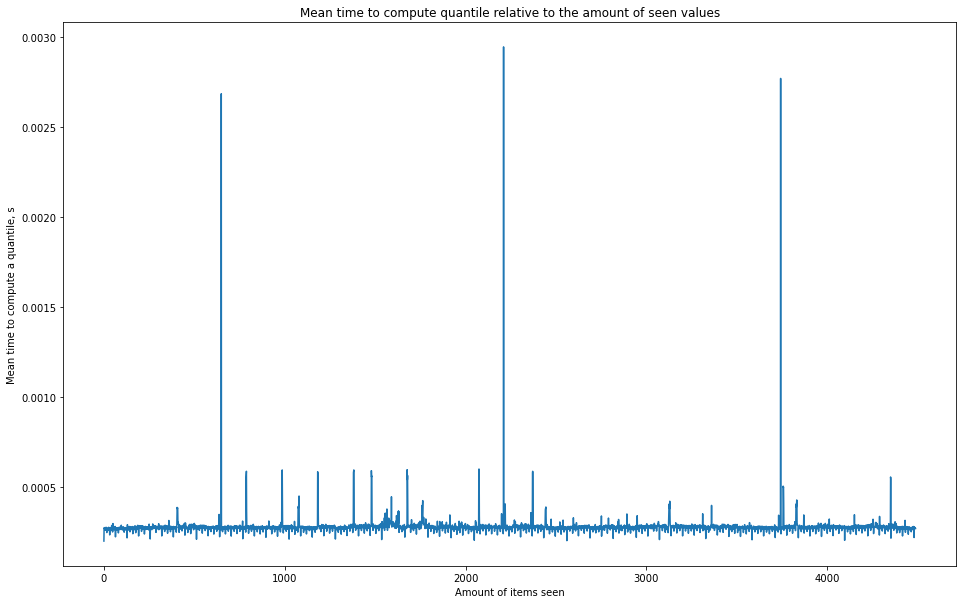

In [4]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,10))
plt.plot(times[0])
plt.xlabel('Amount of items seen')
plt.ylabel('Mean time to compute a quantile, s')
plt.title('Mean time to compute quantile relative to the amount of seen values')
plt.show()

### Mean time to add new item

Time to add new item is also constant, as was expected (there is no linearity wrt to size of the stream) (peaks are most likely from the creation of sketches)

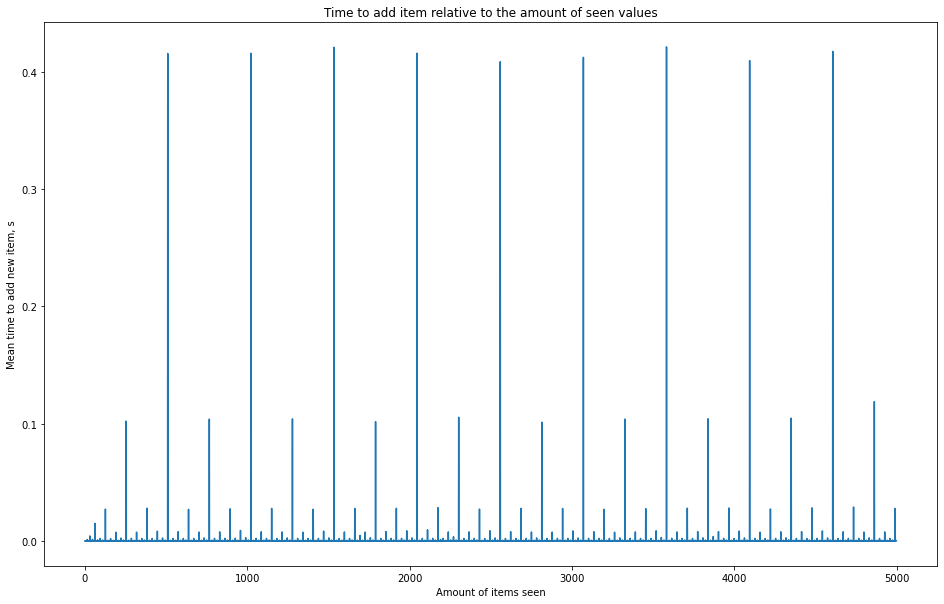

In [5]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,10))
plt.plot(times[1])
plt.xlabel('Amount of items seen')
plt.ylabel('Mean time to add new item, s')
plt.title('Time to add item relative to the amount of seen values')
plt.show()

### Memory consumption

Memory consumption is also linear, as was suggested by the worst amount. We may also notice that the *dance* begins after 512, meaning it most likely isn't at all related to the data structure and only to computation of many values of quantiles

In [6]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,10))
plt.plot(np.array(times[2])/10**6)
plt.xlabel('Amount of items seen')
plt.ylabel('Memory required, MB')
plt.title('Mean time to add item relative to the amount of seen values')
plt.show()

We may also consider another way of thinking about memory consumption.

We have items that are stored and can verify that they are indeed bounded by $O(\dfrac{1}{\epsilon}\log{\dfrac{1}{\epsilon}}\log{W})$ at least for our test

In [13]:
arasu = ArasuFSSW(512, 0.0625)
np.random.seed(42)
values = np.random.normal(size=5000)
pbar = tqdm(enumerate(values))
for ind, v in pbar:
    arasu.insert(v)
    if arasu.current_window_size == arasu.W:
        quantile_summary = arasu.get_Q()
        assert len(quantile_summary) < ((1/arasu.eps)*(np.log2(1/arasu.eps))*np.log2(arasu.W))